# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [2]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
2033,C-1517922h,VW Polo,economy,petrol,4.50,2013,47240,2018,32.04,engine_overheat
2085,B-1448242P,VW Tiguan,economy,petrol,4.48,2017,135569,2019,28.72,gear_stick
2276,O18445397U,Smart Coupe,economy,petrol,3.74,2017,132854,2017,29.40,break_bug
469,u-1140095Q,Kia Rio,economy,petrol,4.54,2014,62490,2015,40.41,engine_overheat
270,y-1123775i,Renault Kaptur,standart,petrol,6.24,2014,61969,2016,32.85,gear_stick


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [3]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
643785,p11937794g,t11482362Y,k1F,2020-03-25,5.83,4,27,40,66.000000,0,1.116563e+02,0,17.033580,-6.998
531527,A90736374o,l12294446D,J1S,2020-03-10,7.91,66,787,40,103.534303,1,2.020494e+03,0,14.287306,8.903
223807,x12691653l,P56763603O,t1Y,2020-01-23,3.58,22,282,31,71.000000,2,3.850682e+02,0,NaN,-29.877
398543,q22134199y,c-3559292Z,s1n,2020-02-14,4.97,32613,521802,47,67.000000,0,1.555513e+06,0,-1.144464,-7.885
452361,Q20197128v,f76040339F,V1b,2020-03-12,4.48,33,258,30,65.000000,4,9.702641e+02,0,-7.378001,-16.168


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [4]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
2794,41,7.0,14,3.0,U11660013j,0,2019-11-19
8412,18,9.3,409,21.0,H16888910M,1,2020-5-27
12754,20,9.2,968,14.0,Y90143731t,1,2020-10-23
13951,31,7.6,993,3.0,D21283105M,0,2020-10-29
11288,22,7.7,1775,2.0,D88181052n,1,2018-5-8


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [5]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
51391,x-7526060y,BW,2020-4-19 11:30,repair,5.2,10
46435,i13542684X,UB,2019-6-17 16:45,repair,3.6,6
65237,l-1026528H,JJ,2019-8-8 4:33,reparking,1.0,24
117911,f91083403C,AK,2021-6-24 15:31,reparking,8.0,39
32255,k-2258315m,FC,2020-1-25 15:12,repair,5.0,10


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

In [6]:
rides_info

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.246920,0,1.115260,2.909
1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,197.520662,0,1.650465,4.133
2,v88009926E,A-1049127W,g1p,2020-01-02,6.01,20,315,61,81.959675,0,1276.328206,0,2.599112,2.461
3,t14229455i,A-1049127W,S1c,2020-01-02,0.26,19,205,32,128.000000,0,535.680831,0,3.216255,0.909
4,W17067612E,A-1049127W,X1b,2020-01-03,1.21,56,554,38,90.000000,1,1729.143367,0,2.716550,-1.822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739495,I15732675M,z91796444U,m1z,2020-03-30,7.42,164,2290,49,54.586302,0,2274.772387,0,6.137593,-39.752
739496,r51579957X,z91796444U,t1P,2020-03-30,4.19,26,412,46,73.000000,0,515.580231,0,6.703367,-38.480
739497,l15212727I,z91796444U,z1A,2020-03-31,3.40,23,178,37,71.000000,1,444.846677,0,6.255344,-45.080
739498,Z78949958q,z91796444U,w1R,2020-04-01,9.02,5,75,48,87.000000,1,179.464361,0,7.759949,-60.193


### rides features

In [7]:
rides_features = rides_info.groupby('car_id', as_index=False).agg(
    min_rating=('rating', 'min'),
    mean_rating=('rating', 'mean'),
    total_distance=('distance', 'sum'),
    max_speed=('speed_max', 'max'),
    total_trips=('ride_id', 'count')
)
rides_grouped = rides_info.groupby('car_id')
# Вычисление признака feature_min_max_diff
feature_min_max_diff = rides_grouped['deviation_normal'].max() - rides_grouped['deviation_normal'].min()

# Вычисление признака feature_corner
def calculate_slope(x, y):
    return np.polyfit(x, y, 1)[0]

feature_corner = rides_grouped.apply(lambda group: calculate_slope(group.index, group['user_ride_quality']))

# Вычисление признака feature_mean
feature_mean = rides_grouped['deviation_normal'].mean()

# Вычисление признака feature_shift
first_derivative = rides_grouped['deviation_normal'].apply(lambda x: np.gradient(x))
feature_shift = first_derivative.apply(lambda x: np.argmax(np.diff(np.sign(x)) != 0))

# Вычисление признака feature_start
feature_start = rides_grouped['deviation_normal'].first()

feature_min_max_diff = feature_min_max_diff.reset_index(name='feature_min_max_diff')
feature_corner = feature_corner.reset_index(name='feature_corner')

# Соединение всех признаков
rides_features = rides_features.merge(feature_min_max_diff, on='car_id', how='left')
rides_features = rides_features.merge(feature_corner, on='car_id', how='left')
rides_features = rides_features.merge(feature_mean, on='car_id', how='left')
rides_features = rides_features.merge(feature_shift, on='car_id', how='left')
rides_features = rides_features.merge(feature_start, on='car_id', how='left')

# Слияние полученного датасета с основным датасетом
car_train = pd.merge(car_train, rides_features, on='car_id', how='left')


### driver features

In [8]:
# Сначала объединим датасеты rides_info и driver_info по столбцу user_id
merged_data = pd.merge(rides_info, driver_info, on='user_id', how='left')

# Затем сгруппируем данные по car_id и вычислим необходимые статистики
driver_features = merged_data.groupby('car_id').agg(
    driver_avg_age=('age', 'mean'),
    driver_avg_rating=('user_rating', 'mean'),
    driver_avg_incidents=('user_time_accident', 'mean')
)

# Присоединяем полученные признаки к rides_features
driver_features.reset_index(inplace=True)

car_train = pd.merge(car_train, driver_features, on='car_id', how='left')


### fix features

In [9]:
# Группировка данных по машинам и вычисление среднего времени ремонта
average_repair_time = fix_info.groupby('car_id')['work_duration'].mean().reset_index()
average_repair_time.rename(columns={'work_duration': 'avg_repair_time'}, inplace=True)

# Подсчет числа ремонтов для каждой машины
repair_counts = fix_info['car_id'].value_counts().reset_index()
repair_counts.columns = ['car_id', 'repair_count']

# Вычисление средней степени износа для каждой машины
average_destroy_degree = fix_info.groupby('car_id')['destroy_degree'].mean().reset_index()
average_destroy_degree.rename(columns={'destroy_degree': 'avg_destroy_degree'}, inplace=True)

car_train = pd.merge(car_train, average_repair_time, on='car_id', how='left')
car_train = pd.merge(car_train, repair_counts, on='car_id', how='left')
car_train = pd.merge(car_train, average_destroy_degree, on='car_id', how='left')
car_train


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,feature_corner,deviation_normal_x,deviation_normal_y,deviation_normal,driver_avg_age,driver_avg_rating,driver_avg_incidents,avg_repair_time,repair_count,avg_destroy_degree
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,-0.012377,-0.120391,11,0.000,33.511494,8.229885,17.724138,26.657143,35,3.048571
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,0.147758,6.050011,2,-7.057,34.988506,7.988506,6.965517,24.942857,35,2.917143
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,NaN,-2.223954,4,-0.000,32.839080,7.843103,9.775862,26.142857,35,3.740000
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,-0.028008,14.771948,3,-0.833,34.977011,8.524138,19.991304,28.771429,35,4.085714
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,-0.010186,12.455678,1,-0.160,34.298851,8.112069,15.758333,28.028571,35,3.880000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,...,-0.046928,2.914989,1,11.105,32.632184,8.124138,20.203390,23.941176,34,3.900000
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,...,-0.060359,-18.805856,1,-0.506,34.977011,8.150575,18.041322,25.676471,34,1.935294
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,...,NaN,-7.651776,0,5.281,33.287356,7.783908,8.804598,23.441176,34,2.782353
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,...,-0.073751,0.468718,3,2.417,31.977011,8.084483,17.008547,25.205882,34,3.441176


## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [10]:
constant_columns = [col for col in car_train.columns if car_train[col].nunique() == 1]
constant_columns

['total_trips']

In [11]:
unique_columns = [col for col in car_train.columns if car_train[col].nunique() == len(car_train)]
unique_columns

['car_id', 'total_distance']

In [12]:
# Удаление констант
car_train.drop(columns=constant_columns, inplace=True)

# Удаление столбцов с уникальными значениями 
car_train.drop(columns=['car_id'], inplace=True)

In [24]:
#Добавим рандомные признаки в датасет
car_train['random_int'] = np.random.randint(-20, 200, car_train.shape[0]) # Целочисленный признак
car_train['random_num'] = np.random.random(size = car_train.shape[0]) # Признак типа float с равномерным распределением
car_train['random_norm'] = np.random.normal(loc = 4, scale = 1.5, size = car_train.shape[0]) # Признак с нормальным распределением



In [25]:
list_random_feature=['random_int', 'random_num', 'random_norm']

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'min_rating', 'mean_rating', 'total_distance', 'max_speed', 'feature_min_max_diff', 'feature_corner', 'deviation_normal_x', 'deviation_normal_y', 'deviation_normal', 'driver_avg_age', 'driver_avg_rating', 'driver_avg_incidents', 'avg_repair_time', 'repair_count', 'avg_destroy_degree', 'random_int', 'random_num', 'random_norm']


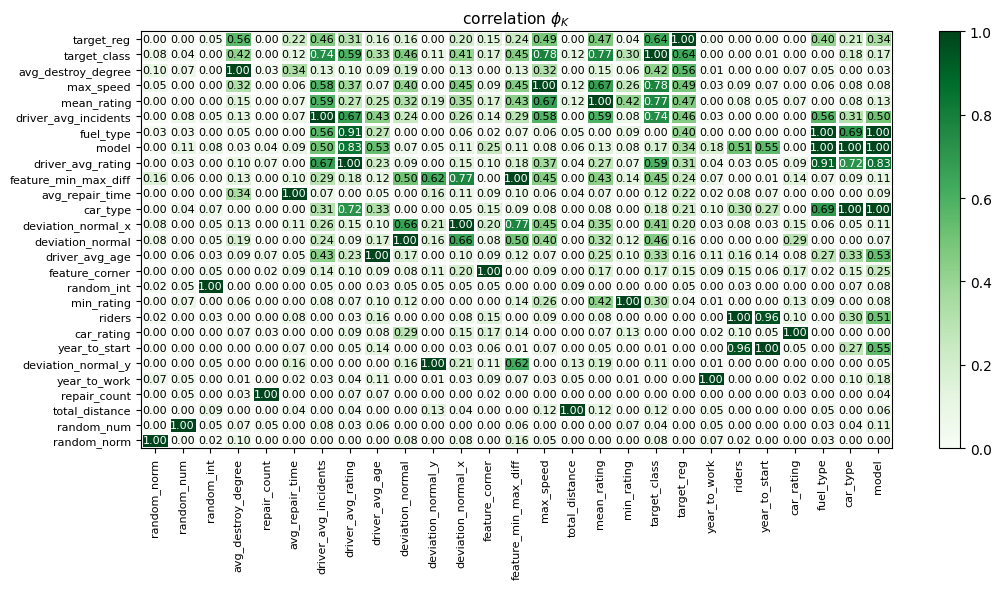

In [26]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

phik_overview = car_train.phik_matrix().round(2).sort_values('target_reg')

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

In [27]:
bad_feature_phik=['total_distance', 'year_to_work', 'min_rating', 'car_rating',  'riders',  'year_to_start', 'deviation_normal_y', 'repair_count']

In [28]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split

drop_cols = ['target_class', 'target_reg']
cat_cols = ['car_type', 'fuel_type', 'model']

X = car_train.drop(drop_cols, axis=1, errors = 'ignore')
y = car_train['target_class'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = CatBoostClassifier(random_state=42,
                           cat_features=cat_cols,
                           thread_count=-1)
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=100, plot=False, 
          early_stopping_rounds=100)

Learning rate set to 0.109335
0:	learn: 1.7406498	test: 1.7606420	best: 1.7606420 (0)	total: 51.1ms	remaining: 51.1s
100:	learn: 0.0926579	test: 0.1433761	best: 0.1433761 (100)	total: 5.95s	remaining: 53s
200:	learn: 0.0562882	test: 0.1232714	best: 0.1232714 (200)	total: 11.7s	remaining: 46.7s
300:	learn: 0.0365081	test: 0.1134864	best: 0.1134864 (300)	total: 17.4s	remaining: 40.5s
400:	learn: 0.0258873	test: 0.1093930	best: 0.1093930 (400)	total: 27.6s	remaining: 41.2s
500:	learn: 0.0195748	test: 0.1061556	best: 0.1061556 (500)	total: 34.5s	remaining: 34.4s
600:	learn: 0.0148803	test: 0.1036176	best: 0.1036073 (595)	total: 44.7s	remaining: 29.7s
700:	learn: 0.0118957	test: 0.1037525	best: 0.1032407 (610)	total: 57.6s	remaining: 24.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1032407467
bestIteration = 610

Shrink model to first 611 iterations.


In [29]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [30]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.9700854700854701


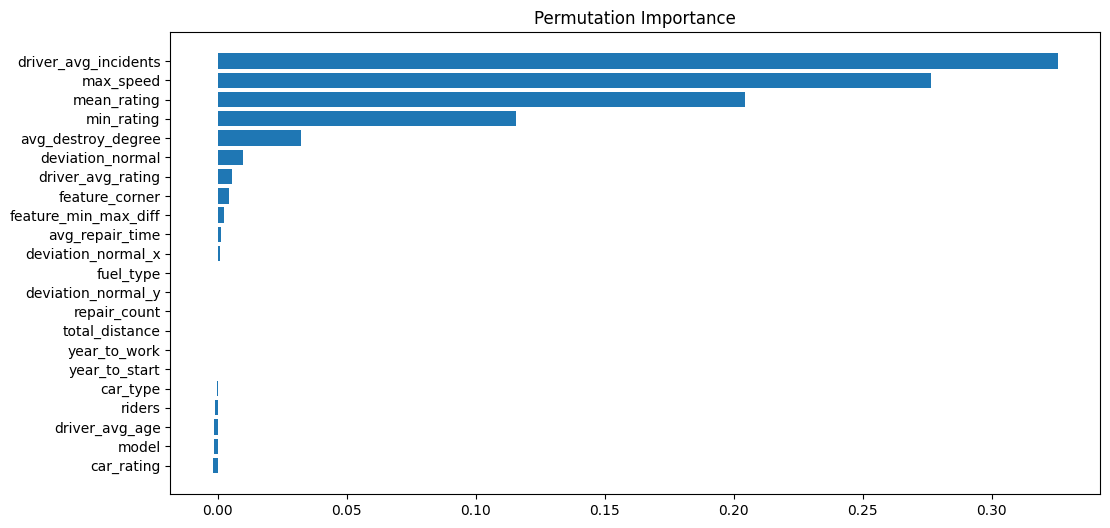

In [18]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

In [31]:
bad_feature_PI = [x for x in list(np.array(X.columns)[sorted_idx][:14]) if x not in list_random_feature]
bad_feature_PI

['car_rating',
 'model',
 'driver_avg_age',
 'riders',
 'car_type',
 'year_to_start',
 'year_to_work',
 'total_distance',
 'repair_count',
 'deviation_normal_y',
 'fuel_type',
 'deviation_normal_x',
 'avg_repair_time',
 'feature_min_max_diff']

In [32]:
summary = model.select_features(X_train, y_train, 
                      eval_set=(X_test, y_test),
                      features_for_select='0-24',
                      num_features_to_select=11,
                      steps=1,
                      train_final_model=False,
                      logging_level='Silent')

In [33]:
# Посмотрим на список отобранных фичей (не отранжирован по важности)
print(summary['selected_features_names'])
# И на лучшее значение лосса
print(f"Best loss: {summary['loss_graph']['loss_values'][-1]}")

['car_type', 'min_rating', 'mean_rating', 'max_speed', 'feature_min_max_diff', 'feature_corner', 'deviation_normal_x', 'deviation_normal', 'driver_avg_rating', 'driver_avg_incidents', 'avg_destroy_degree']
Best loss: 0.10185960531963405


In [34]:
summary

{'selected_features': [1, 7, 8, 10, 11, 12, 13, 15, 17, 18, 21],
 'eliminated_features_names': ['year_to_work',
  'total_distance',
  'random_int',
  'random_norm',
  'year_to_start',
  'riders',
  'fuel_type',
  'repair_count',
  'avg_repair_time',
  'driver_avg_age',
  'car_rating',
  'deviation_normal_y',
  'random_num',
  'model'],
 'loss_graph': {'main_indices': [0],
  'removed_features_count': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  'loss_values': [0.10104546017011498,
   0.10025298779523237,
   0.09944907968916161,
   0.09903444593401114,
   0.09866194671384443,
   0.09839413949034861,
   0.09835726536069768,
   0.09839270307505316,
   0.09843558646768519,
   0.09875440137427752,
   0.09916935757930667,
   0.09958734666347775,
   0.1000906256137304,
   0.10082056453202289,
   0.10185960531963405]},
 'eliminated_features': [6, 9, 22, 24, 4, 5, 2, 20, 19, 16, 3, 14, 23, 0],
 'selected_features_names': ['car_type',
  'min_rating',
  'mean_rating',
  'max_speed',
  'fe

Все рандомные фичи были распознаны 

In [35]:
bad_feature_sf=summary['eliminated_features_names']

In [36]:
set(bad_feature_phik) & set(bad_feature_PI) & set(bad_feature_sf)

{'car_rating',
 'deviation_normal_y',
 'repair_count',
 'riders',
 'total_distance',
 'year_to_start',
 'year_to_work'}

In [37]:
set(bad_feature_phik+bad_feature_PI+bad_feature_sf)

{'avg_repair_time',
 'car_rating',
 'car_type',
 'deviation_normal_x',
 'deviation_normal_y',
 'driver_avg_age',
 'feature_min_max_diff',
 'fuel_type',
 'min_rating',
 'model',
 'random_int',
 'random_norm',
 'random_num',
 'repair_count',
 'riders',
 'total_distance',
 'year_to_start',
 'year_to_work'}

In [38]:
drop_features_list=set(bad_feature_phik+bad_feature_PI+bad_feature_sf)

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `y` таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [131]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Обучение модели на всех фичах без удаления из прошлого пункта

In [164]:

features2drop = ["car_id", 'total_trips'] # то, что надо выбросить
targets = ["target_class", "target_reg"] # таргеты
cat_features = ['car_type', 'fuel_type', 'model']  # категориальные признаки

# Отбираем итоговый набор признаков для использования моделью
filtered_features = [i for i in car_train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 3 ['car_type', 'fuel_type', 'model']
Числовые признаки: 19 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'min_rating', 'mean_rating', 'total_distance', 'max_speed', 'feature_min_max_diff', 'feature_corner', 'deviation_normal_x', 'deviation_normal_y', 'deviation_normal', 'driver_avg_age', 'driver_avg_rating', 'driver_avg_incidents', 'avg_repair_time', 'repair_count', 'avg_destroy_degree']
Целевые переменные ['target_class', 'target_reg']


In [165]:

X = car_train[filtered_features].drop(targets, axis=1, errors="ignore")
y = car_train["target_class"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(thread_count=-1,
                         random_seed=42,
                         cat_features=cat_features)

clf.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.109335
0:	learn: 1.7738434	test: 1.7903626	best: 1.7903626 (0)	total: 31.5ms	remaining: 31.5s


200:	learn: 0.0529646	test: 0.1138530	best: 0.1137407 (194)	total: 8.04s	remaining: 32s
400:	learn: 0.0254533	test: 0.1029401	best: 0.1028159 (390)	total: 16s	remaining: 23.9s
600:	learn: 0.0151127	test: 0.0992375	best: 0.0992375 (600)	total: 24s	remaining: 15.9s
800:	learn: 0.0102848	test: 0.0983909	best: 0.0982549 (776)	total: 32s	remaining: 7.95s
999:	learn: 0.0074389	test: 0.0968202	best: 0.0966103 (984)	total: 39.9s	remaining: 0us

bestTest = 0.09661033299
bestIteration = 984

Shrink model to first 985 iterations.


In [166]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.9700854700854701


Удалим фичи которые плохо себя показали

In [156]:

features2drop = ["car_id", 'total_trips'] # то, что надо выбросить
targets = ["target_class", "target_reg"] # таргеты
cat_features = [i for i in ['car_type', 'fuel_type', 'model'] if i not in drop_features_list]  # категориальные признаки

# Отбираем итоговый набор признаков для использования моделью
filtered_features = [i for i in car_train.columns if (i not in targets and i not in features2drop and i not in drop_features_list)]
num_features = [i for i in filtered_features if i not in cat_features]

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 1 ['car_type']
Числовые признаки: 8 ['mean_rating', 'max_speed', 'feature_corner', 'deviation_normal_x', 'deviation_normal', 'driver_avg_rating', 'driver_avg_incidents', 'avg_destroy_degree']
Целевые переменные ['target_class', 'target_reg']


In [157]:

X = car_train[filtered_features].drop(targets, axis=1, errors="ignore")
y = car_train["target_class"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf1 = CatBoostClassifier(thread_count=-1,
                         random_seed=42,
                         cat_features=cat_features)

clf1.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.109335
0:	learn: 1.7369659	test: 1.7597120	best: 1.7597120 (0)	total: 23ms	remaining: 23s


200:	learn: 0.0746194	test: 0.1782474	best: 0.1782474 (200)	total: 5.54s	remaining: 22s
400:	learn: 0.0362681	test: 0.1713422	best: 0.1701409 (355)	total: 11.2s	remaining: 16.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1701409121
bestIteration = 355

Shrink model to first 356 iterations.


In [158]:
y_pred = clf1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.9572649572649573


# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

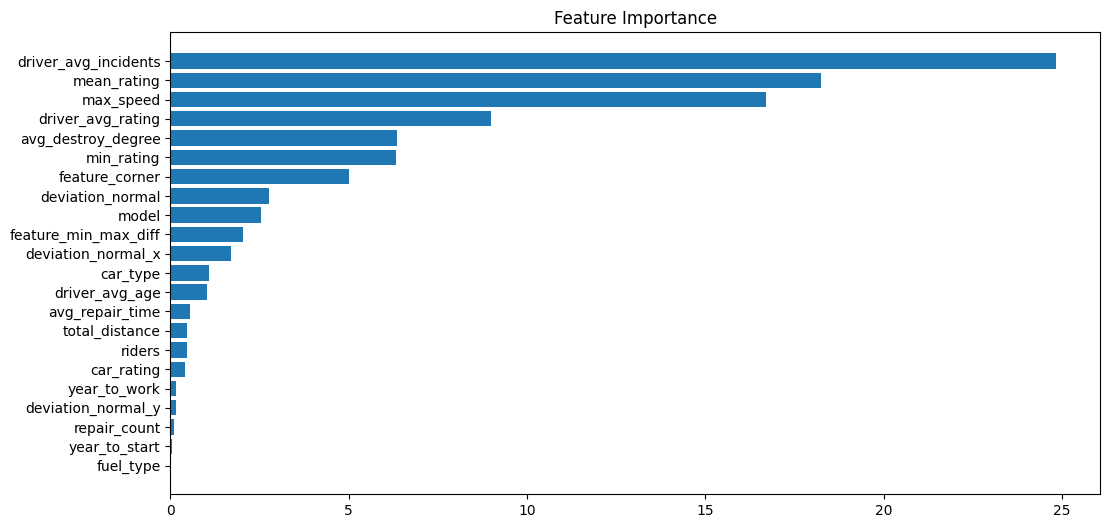

In [167]:
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

In [168]:
# посмотрим на важность признаков катбуста
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,driver_avg_incidents,24.839391
1,mean_rating,18.234575
2,max_speed,16.694381
3,driver_avg_rating,8.991744
4,avg_destroy_degree,6.358095
5,min_rating,6.324036
6,feature_corner,4.996379
7,deviation_normal,2.777161
8,model,2.548906
9,feature_min_max_diff,2.037958


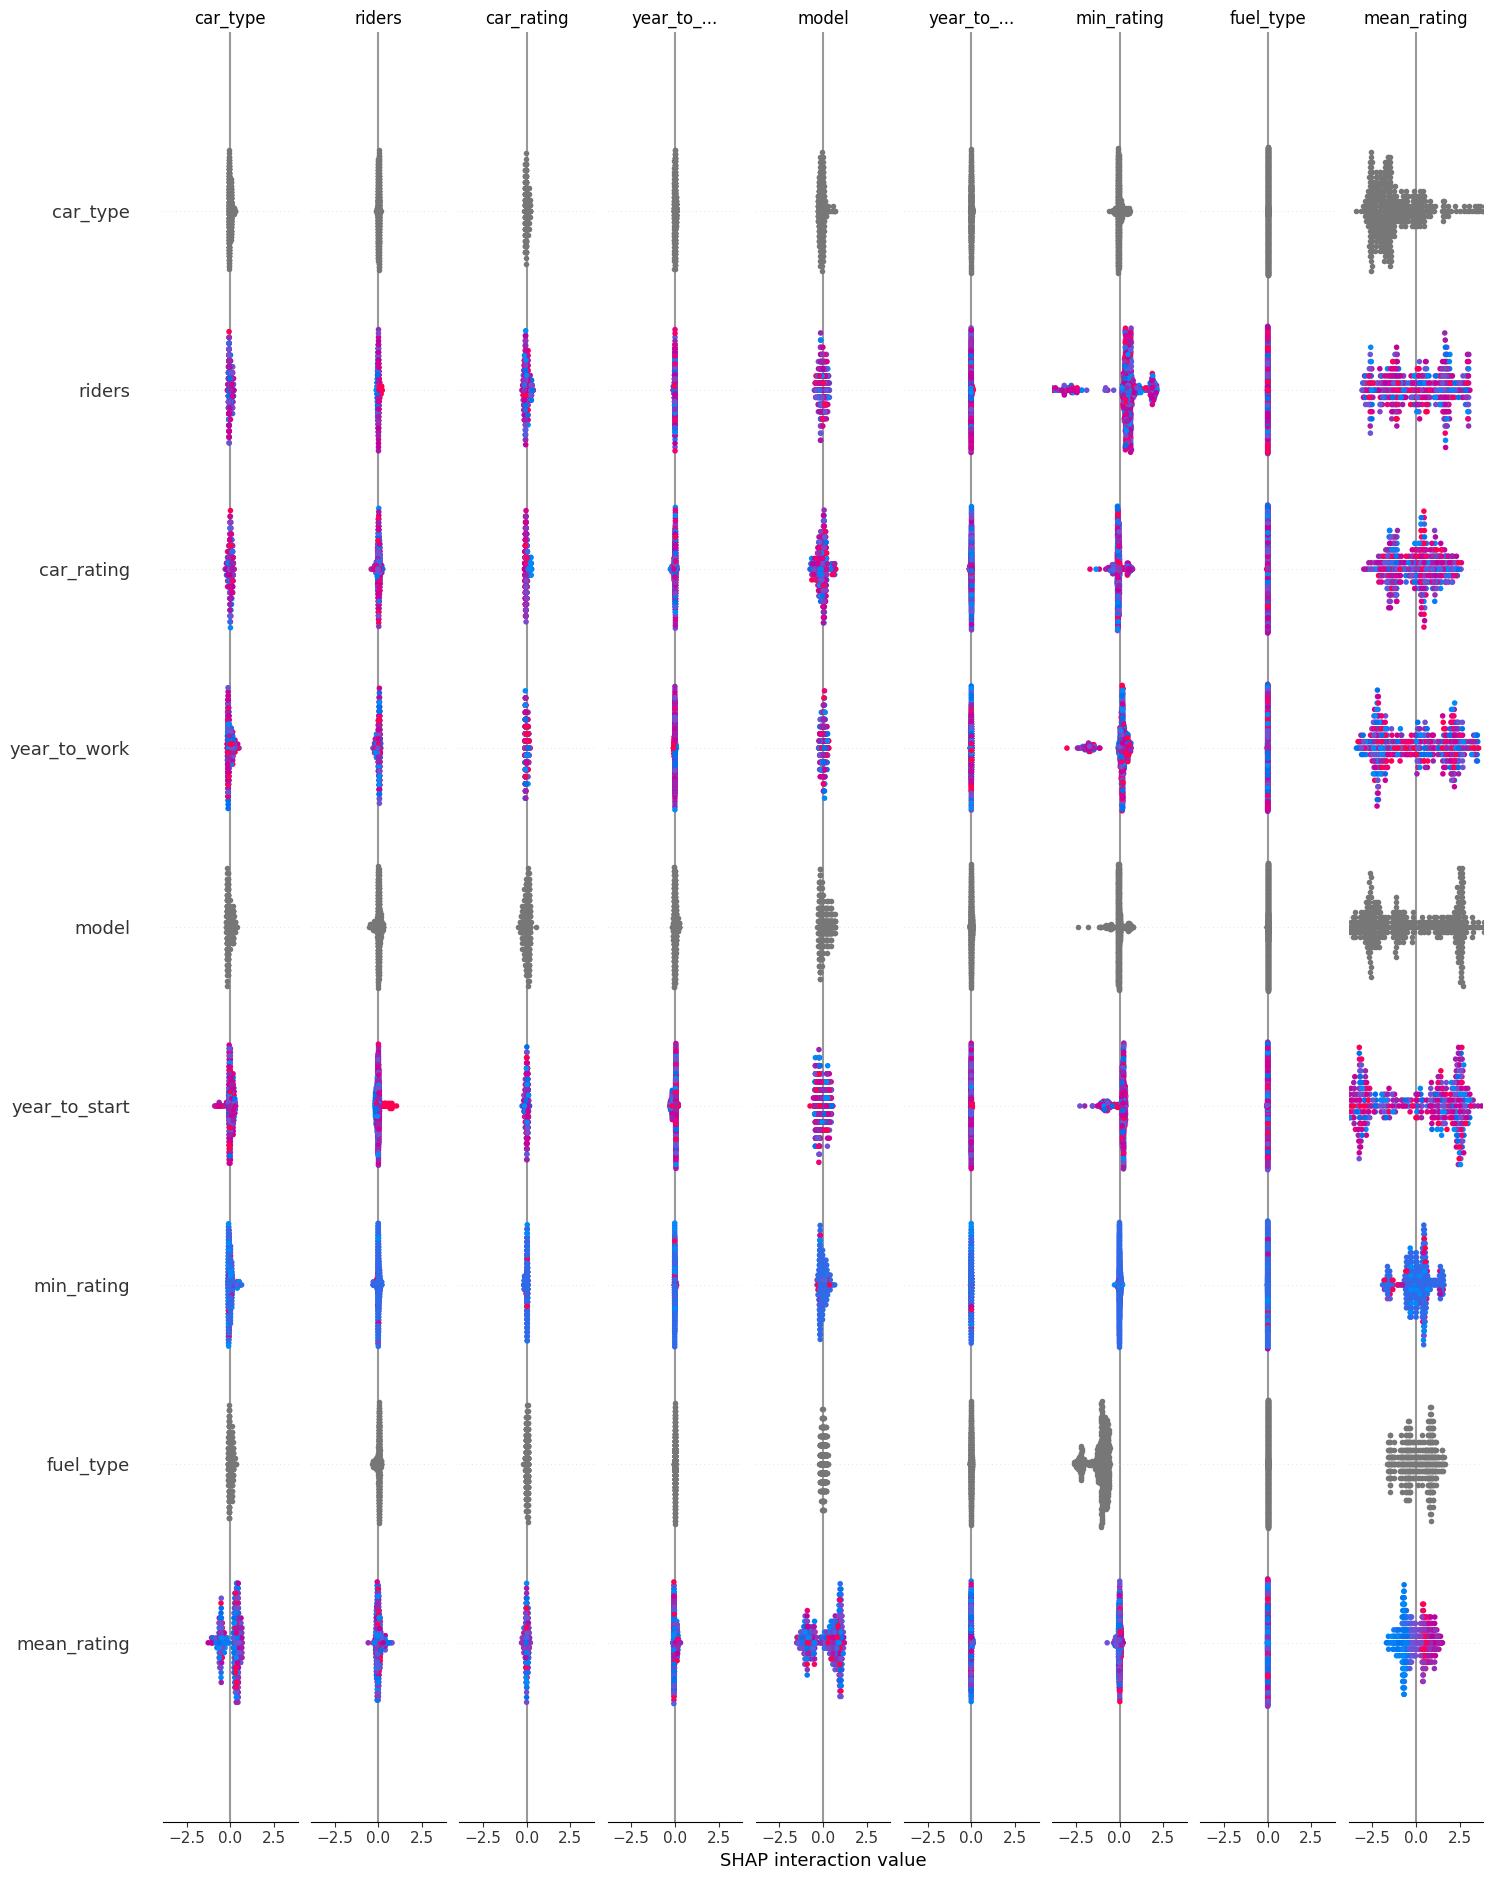

In [181]:
import shap
shap.initjs()
# Можем посмотреть влияние фичей на все классы
explainer = shap.TreeExplainer(clf)

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display = 25, plot_size = (15, 5))

In [176]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=clf.classes_))

                 precision    recall  f1-score   support

    another_bug       0.96      0.95      0.96        58
      break_bug       1.00      1.00      1.00        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       0.91      0.88      0.90        49
    engine_fuel       0.95      1.00      0.97        58
engine_ignition       0.98      1.00      0.99        58
engine_overheat       1.00      0.98      0.99        48
     gear_stick       1.00      1.00      1.00        51
    wheel_shake       0.90      0.90      0.90        39

       accuracy                           0.97       468
      macro avg       0.97      0.97      0.97       468
   weighted avg       0.97      0.97      0.97       468



In [177]:
rep = pd.DataFrame(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=clf.classes_,
                            output_dict=True)).T
rep['support'] = rep.support.apply(int)
rep.style.background_gradient(cmap='viridis', subset=pd.IndexSlice['another_bug':'wheel_shake', :'f1-score'])

,precision,recall,f1-score,support
another_bug,0.964912,0.948276,0.956522,58
break_bug,1.000000,1.000000,1.000000,56
electro_bug,1.000000,1.000000,1.000000,51
engine_check,0.914894,0.877551,0.895833,49
engine_fuel,0.950820,1.000000,0.974790,58
engine_ignition,0.983051,1.000000,0.991453,58
engine_overheat,1.000000,0.979167,0.989474,48
gear_stick,1.000000,1.000000,1.000000,51
wheel_shake,0.897436,0.897436,0.897436,39
accuracy,0.970085,0.970085,0.970085,0


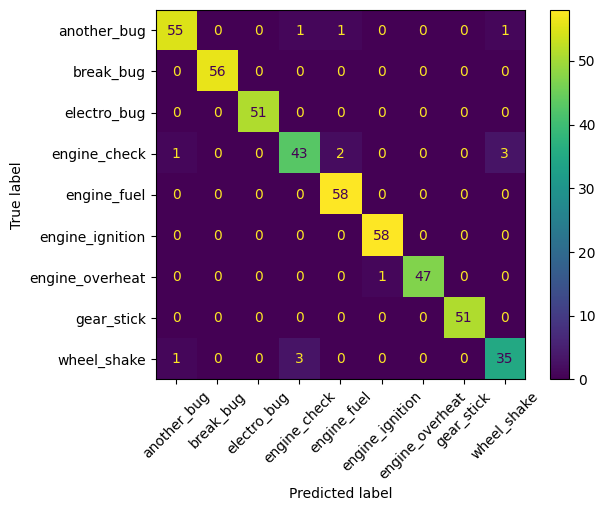

In [179]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, xticks_rotation = 45)


Интерпретация результатов и выводы:

Визуализация важности признаков в CatBoost позволяет увидеть, какие признаки оказывают наибольшее влияние на прогнозы модели. Однако, надо учитывать, что для сильно скоррелированных признаков важность может быть недооценена.

Waterfall plot с использованием SHAP дает представление о том, как каждый признак вносит вклад в предсказание модели для отдельного наблюдения. Это помогает понять, какие признаки вносят наибольший вклад в конкретные прогнозы - не могу добиться нормально вида(.

Classification report предоставляет полную информацию о точности, полноте, F1-мере и других метриках для каждого класса. Класс wheel_shake и engine_check имееют худшие метрики.

Матрица смежности (confusion matrix) позволяет оценить, в каких классах модель делает больше всего ошибок. Это помогает выявить слабые стороны модели и возможные направления для улучшения. Видно что для классов которые имеют худшие метрики меньше всего примеров.

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [43]:
features2drop = ["car_id", 'total_trips'] # то, что надо выбросить
targets = ["target_class", "target_reg"] # таргеты
cat_features = ['car_type', 'fuel_type', 'model']  # категориальные признаки

# Отбираем итоговый набор признаков для использования моделью
filtered_features = [i for i in car_train.columns if (i not in targets and i not in features2drop and i not in list_random_feature)]
num_features = [i for i in filtered_features if i not in cat_features]

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 3 ['car_type', 'fuel_type', 'model']
Числовые признаки: 19 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'min_rating', 'mean_rating', 'total_distance', 'max_speed', 'feature_min_max_diff', 'feature_corner', 'deviation_normal_x', 'deviation_normal_y', 'deviation_normal', 'driver_avg_age', 'driver_avg_rating', 'driver_avg_incidents', 'avg_repair_time', 'repair_count', 'avg_destroy_degree']
Целевые переменные ['target_class', 'target_reg']


In [53]:
from sklearn.metrics import accuracy_score
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, train_test_split

def fit_catboost(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'iterations' : 400, 
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 50),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.8),
        
        "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced", "None"]),
        "depth": trial.suggest_int("depth", 3, 9),
        
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "used_ram_limit": "14gb",
        "eval_metric": "Accuracy", 
    }

    
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 20)
        
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        

    clf = CatBoostClassifier(
        **param,
        thread_count=-1,
        random_seed=42,
        cat_features=cat_features,
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        verbose=0,
        plot=False,
        early_stopping_rounds=5,
    )

    y_pred = clf.predict(X_val)
    return clf, y_pred

def objective(trial, return_models=False):
    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    X_train = car_train[filtered_features].drop(targets, axis=1, errors="ignore")
    y_train = car_train["target_class"]

    scores, models = [], []
    
    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_catboost(trial, train_data, valid_data) # Определили выше
        scores.append(accuracy_score(y_pred, valid_data[1]))
        models.append(model)
        break
         

    result = np.mean(scores)
    
    if return_models:
        return result, models
    else:
        return result
    
study = optuna.create_study(direction="maximize")
study.optimize(objective,
               n_trials=600,
               n_jobs = -1,
               show_progress_bar=True,)



[I 2024-03-26 14:34:02,678] A new study created in memory with name: no-name-8e6eca01-afe2-4748-a9ac-19f7ec7f91b1


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2024-03-26 14:34:03,226] Trial 5 finished with value: 0.1258023106546855 and parameters: {'learning_rate': 0.007217001729593675, 'l2_leaf_reg': 4, 'colsample_bylevel': 0.030835447284866424, 'auto_class_weights': 'None', 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 5 with value: 0.1258023106546855.
[I 2024-03-26 14:34:04,257] Trial 2 finished with value: 0.8292682926829268 and parameters: {'learning_rate': 0.009152429642324, 'l2_leaf_reg': 19, 'colsample_bylevel': 0.06158936551193799, 'auto_class_weights': 'None', 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7167937389312313}. Best is trial 2 with value: 0.8292682926829268.
[I 2024-03-26 14:34:04,727] Trial 12 finished with value: 0.9319640564826701 and parameters: {'learning_rate': 0.0013705284168717639, 'l2_leaf_reg': 5, 'colsample_bylevel': 0.20234360307617097, 'auto_class_weights': 'Balanced', 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoul

In [54]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.9653401797175867, params {'learning_rate': 0.0017951672072522634, 'l2_leaf_reg': 2, 'colsample_bylevel': 0.2588210628804328, 'auto_class_weights': 'SqrtBalanced', 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.830649916012709}


In [56]:
optimal_params=study.best_trial.params

In [57]:
clf = CatBoostClassifier(**optimal_params, thread_count=-1, random_seed=42, cat_features=cat_features)
clf.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

# Получение предсказаний на тестовом наборе данных
y_pred = clf.predict(X_test)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)

# Вывод результата
print("Accuracy with Optuna-tuned model: {:.4f}".format(accuracy))

0:	learn: 2.1871193	test: 2.1873082	best: 2.1873082 (0)	total: 190ms	remaining: 3m 10s
200:	learn: 1.2997342	test: 1.3261151	best: 1.3261151 (200)	total: 36.2s	remaining: 2m 23s
400:	learn: 0.8988929	test: 0.9332902	best: 0.9332902 (400)	total: 1m 13s	remaining: 1m 49s
600:	learn: 0.6650520	test: 0.7023661	best: 0.7023661 (600)	total: 1m 48s	remaining: 1m 12s
800:	learn: 0.5135024	test: 0.5519609	best: 0.5519609 (800)	total: 2m 25s	remaining: 36s
999:	learn: 0.4117101	test: 0.4510276	best: 0.4510276 (999)	total: 3m	remaining: 0us

bestTest = 0.4510276097
bestIteration = 999

Accuracy with Optuna-tuned model: 0.9679


Несмотря на то что Optuna стремится найти оптимальные гиперпараметры, некоторые комбинации гиперпараметров могут быть лучше в теории, чем другие, но на практике могут не давать наилучший результат из-за особенностей данных или модели.

В целом, небольшое расхождение в точности модели между результатами с использованием Optuna и без него не является необычным.

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.